# Bitcoin Time Series Forecasting with RNN & LSTM

## Project Overview

Bitcoin adalah cryptocurrency paling lama berjalan dan paling terkenal, pertama kali dirilis sebagai open source pada tahun 2009 oleh Satoshi Nakamoto anonim. Bitcoin berfungsi sebagai media pertukaran digital yang terdesentralisasi, dengan transaksi diverifikasi dan dicatat dalam buku besar yang didistribusikan secara publik (blockchain) tanpa memerlukan otoritas pencatatan tepercaya atau perantara pusat. Blok transaksi berisi hash kriptografi SHA-256 dari blok transaksi sebelumnya, dan dengan demikian "dirantai" bersama, berfungsi sebagai catatan abadi dari semua transaksi yang pernah terjadi. Seperti halnya mata uang/komoditas apa pun di pasar, perdagangan bitcoin dan instrumen keuangan segera mengikuti adopsi bitcoin oleh publik dan terus berkembang. Jika Anda belum mengetahui apa itu Bitcoin, maka dapatkan beberapa pengetahuan tentang Bitcoin di sini.

## IMPORT DATA & MODULE

### Load data menggunakan API KAGGLE

In [1]:
# C:\Users\USER\.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syahmisajid12","key":"****************"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

Load Data dari Kaggle

In [3]:
!kaggle datasets download -d mczielinski/bitcoin-historical-data

 82% 82.0M/100M [00:00<00:00, 85.6MB/s]
100% 100M/100M [00:01<00:00, 102MB/s]  


Import Module

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import Function

In [5]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/Syahmi33github/Emotion-Classification/main/helper_functions.py

# Import helper functions we're going to use
from helper_functions import unzip_data

--2023-06-24 12:22:23--  https://raw.githubusercontent.com/Syahmi33github/Emotion-Classification/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11485 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  11.22K  --.-KB/s    in 0s      

2023-06-24 12:22:24 (75.3 MB/s) - ‘helper_functions.py’ saved [11485/11485]



## Exploratory Data Analysis

In [6]:
unzip_data("/content/bitcoin-historical-data.zip")

In [7]:
df = pd.read_csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

In [9]:
df.shape

(4857377, 8)

In [10]:
bit_data = df.copy()
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()
data.head(10)

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
2012-01-05    6.286190
2012-01-06    6.445000
2012-01-07    6.800000
2012-01-08    6.950000
2012-01-09    6.581667
Name: Close, dtype: float64

In [11]:
data.shape

(3376,)

In [12]:
data.isnull().sum()

0

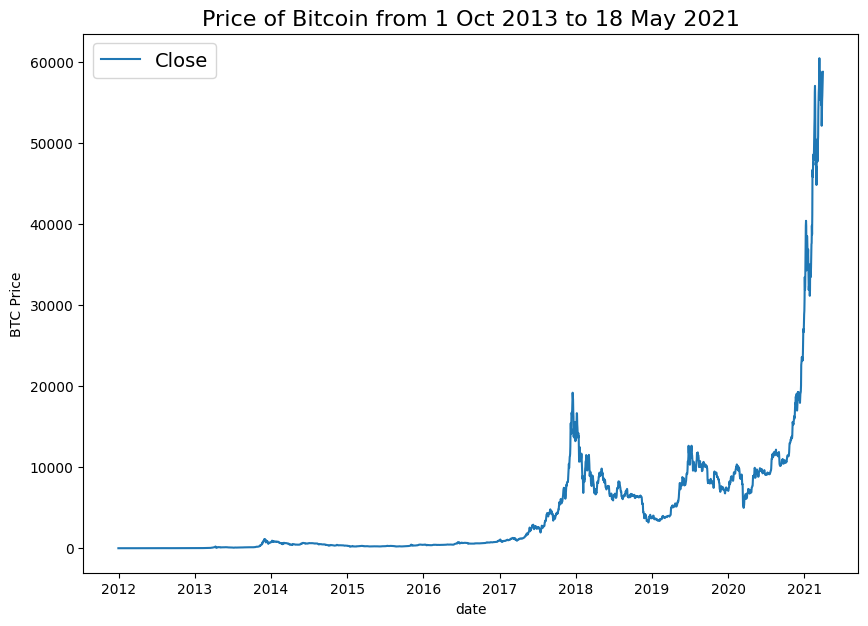

In [13]:
import matplotlib.pyplot as plt
data.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Data Pre Processing

In [14]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 50 # use a week worth of timesteps to predict the horizon

### Split Data

In [15]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [16]:
# Test out the window labelling function
test_windows, test_labels = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [17]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [18]:
import numpy as np

full_windows, full_labels = make_windows(data.values, window_size=50, horizon=HORIZON)
len(full_windows), len(full_labels)

(3326, 3326)

In [19]:
print(full_windows[0])
print(full_labels[0])
print(full_windows[1])

[4.4825     4.80666667 5.         5.2525     5.22333333 6.28619048
 6.445      6.8        6.95       6.58166667 6.603      7.121875
 7.0625     6.9603125  6.41       7.15       6.71428571 6.14166667
 6.24472222 6.22571429 6.835      6.386      6.485      6.4075
 6.49555556 6.28194444 6.185      5.65142857 4.91       5.696
 5.545      5.61902439 5.78875    6.17087719 6.20481481 6.095625
 5.83916667 5.52625    5.672      5.74333333 5.78357143 5.87692308
 5.605      5.6375     5.64818182 5.1930303  4.94526316 4.57558824
 4.6909375  4.39769231]
[4.33166667]
[4.80666667 5.         5.2525     5.22333333 6.28619048 6.445
 6.8        6.95       6.58166667 6.603      7.121875   7.0625
 6.9603125  6.41       7.15       6.71428571 6.14166667 6.24472222
 6.22571429 6.835      6.386      6.485      6.4075     6.49555556
 6.28194444 6.185      5.65142857 4.91       5.696      5.545
 5.61902439 5.78875    6.17087719 6.20481481 6.095625   5.83916667
 5.52625    5.672      5.74333333 5.78357143 5.87692

In [20]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [4.4825     4.80666667 5.         5.2525     5.22333333 6.28619048
 6.445      6.8        6.95       6.58166667 6.603      7.121875
 7.0625     6.9603125  6.41       7.15       6.71428571 6.14166667
 6.24472222 6.22571429 6.835      6.386      6.485      6.4075
 6.49555556 6.28194444 6.185      5.65142857 4.91       5.696
 5.545      5.61902439 5.78875    6.17087719 6.20481481 6.095625
 5.83916667 5.52625    5.672      5.74333333 5.78357143 5.87692308
 5.605      5.6375     5.64818182 5.1930303  4.94526316 4.57558824
 4.6909375  4.39769231] -> Label: [4.33166667]
Window: [4.80666667 5.         5.2525     5.22333333 6.28619048 6.445
 6.8        6.95       6.58166667 6.603      7.121875   7.0625
 6.9603125  6.41       7.15       6.71428571 6.14166667 6.24472222
 6.22571429 6.835      6.386      6.485      6.4075     6.49555556
 6.28194444 6.185      5.65142857 4.91       5.696      5.545
 5.61902439 5.78875    6.17087719 6.20481481 6.095625   5.83916667
 5.52625    5.672      5.7

In [21]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [22]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2660, 666, 2660, 666)

In [23]:
train_windows[:5,-5:], train_labels[:5]

(array([[5.1930303 , 4.94526316, 4.57558824, 4.6909375 , 4.39769231],
        [4.94526316, 4.57558824, 4.6909375 , 4.39769231, 4.33166667],
        [4.57558824, 4.6909375 , 4.39769231, 4.33166667, 4.56071429],
        [4.6909375 , 4.39769231, 4.33166667, 4.56071429, 4.4834375 ],
        [4.39769231, 4.33166667, 4.56071429, 4.4834375 , 4.54222222]]),
 array([[4.33166667],
        [4.56071429],
        [4.4834375 ],
        [4.54222222],
        [4.89095238]]))

In [24]:
# Check to see if same
np.array_equal((train_windows[1,-1:]), train_labels[0])

True

In [25]:
print(train_windows[1,-1:])
print(train_labels[0])

[4.33166667]
[4.33166667]


## Modelling

### Make a modelling checkpoint

In [26]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Model 1: RNN

In [85]:
from keras.models import Model
from keras.layers import Dense, SimpleRNN, Dropout, Flatten, Input

input_shape = (train_windows.shape[1], 1)

# Input layer
inputs = Input(shape=input_shape)

# First RNN layer
x = SimpleRNN(128, activation="relu", return_sequences=True)(inputs)
x = Dropout(0.25)(x)

# Second RNN layer
x = SimpleRNN(256, activation="relu", return_sequences=True)(x)
x = Dropout(0.25)(x)

# Third RNN layer
x = SimpleRNN(512, activation="relu", return_sequences=True)(x)
x = Dropout(0.35)(x)

# Fourth RNN layer
x = SimpleRNN(256, activation="relu", return_sequences=True)(x)
x = Dropout(0.25)(x)

# Fifth RNN layer
x = SimpleRNN(128, activation="relu", return_sequences=True)(x)
x = Dropout(0.25)(x)

# Convert the matrix to 1-line
x = Flatten()(x)

# Output layer
outputs = Dense(1)(x)

# Create the model
model_1 = Model(inputs=inputs, outputs=outputs)

model_1.compile(optimizer="adam", loss="mean_squared_error")
model_1.fit(train_windows, train_labels, epochs=25, batch_size=64,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/25
42/42 [==============================] - 24s 419ms/step - loss: 4410816.0000 - val_loss: 84577920.0000
Epoch 2/25
42/42 [==============================] - 17s 410ms/step - loss: 903259.4375 - val_loss: 39255444.0000
Epoch 3/25
42/42 [==============================] - 25s 602ms/step - loss: 529130.6875 - val_loss: 30258398.0000
Epoch 4/25
42/42 [==============================] - 16s 391ms/step - loss: 533007.1875 - val_loss: 41410592.0000
Epoch 5/25
42/42 [==============================] - 12s 292ms/step - loss: 360780.9375 - val_loss: 54421484.0000
Epoch 6/25
42/42 [==============================] - 18s 428ms/step - loss: 368699.0625 - val_loss: 23681718.0000
Epoch 7/25
42/42 [==============================] - 10s 242ms/step - loss: 455356.7812 - val_loss: 40735252.0000
Epoch 8/25
42/42 [==============================] - 16s 395ms/step - loss: 453056.3750 - val_loss: 20106646.0000
Epoch 9/25
42/42 [==============================] - 10s 246ms/step - loss: 393486.8125 - val_lo

In [86]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 22ms/step - loss: 49349240.0000


49349240.0

In [100]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1")
model_1.evaluate(test_windows, test_labels)

21/21 [==============================] - 1s 21ms/step - loss: 19803714.0000


19803714.0

In [101]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [102]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

21/21 [==============================] - 1s 22ms/step


(666,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([6771.8887, 6641.4834, 6538.2534, 6507.7266, 6498.7197, 6469.3926,
        6438.3027, 6447.1714, 6473.344 , 6500.9575], dtype=float32)>)

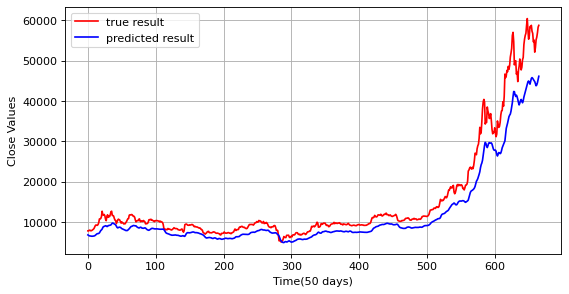

In [103]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_labels,color="r",label="true result")
plt.plot(model_1_preds,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [104]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [105]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [106]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 3170.4219,
 'mse': 19803716.0,
 'rmse': 4450.1367,
 'mape': 20.01894,
 'mase': 8.433455}

### Model 2: LSTM

In [74]:
import tensorflow as tf
from tensorflow.keras import layers

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM

# print(x.shape)

# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)

# x = layers.Dense(32, activation="relu")(x)

output = layers.Dense(HORIZON)(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=output, name="model_2")

model_2.compile(loss="mean_squared_error",optimizer="adam")

model_2.fit(train_windows,
            train_labels,
            epochs=25,
            batch_size=64,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name="model_2")])

Epoch 1/25
42/42 [==============================] - 4s 50ms/step - loss: 1808624.6250 - val_loss: 6503321.0000
Epoch 2/25
42/42 [==============================] - 0s 6ms/step - loss: 424576.1875 - val_loss: 6984816.0000
Epoch 3/25
42/42 [==============================] - 2s 60ms/step - loss: 280961.3125 - val_loss: 3647051.7500
Epoch 4/25
42/42 [==============================] - 2s 45ms/step - loss: 219967.9062 - val_loss: 3438968.2500
Epoch 5/25
42/42 [==============================] - 2s 45ms/step - loss: 197686.6250 - val_loss: 2750325.2500
Epoch 6/25
42/42 [==============================] - 2s 53ms/step - loss: 196534.1406 - val_loss: 2527586.5000
Epoch 7/25
42/42 [==============================] - 0s 11ms/step - loss: 163256.2656 - val_loss: 2604448.5000
Epoch 8/25
42/42 [==============================] - 0s 11ms/step - loss: 157993.5469 - val_loss: 3300821.2500
Epoch 9/25
42/42 [==============================] - 2s 49ms/step - loss: 136287.0625 - val_loss: 2448473.2500
Epoch 10/2

In [75]:
# Evaluate model on test data
model_2.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 1474528.2500


1474528.25

In [78]:
# Load in saved best performing model_1 and evaluate on test data
model_2 = tf.keras.models.load_model("model_experiments/model_2")
model_2.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 1464885.0000


1464885.0

In [79]:
# Make predictions using model_1 on the test dataset and view the results
model_2_preds = make_preds(model_2, test_windows)
len(model_2_preds), model_2_preds[:10]

21/21 [==============================] - 0s 2ms/step


(666,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8358.424 , 8242.882 , 8022.0947, 7916.5244, 7871.824 , 7816.0513,
        7815.2964, 7715.8223, 7612.336 , 7790.053 ], dtype=float32)>)

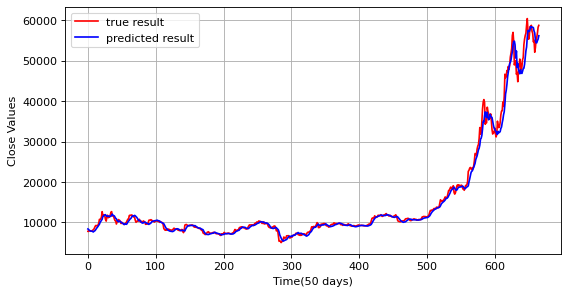

In [80]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_labels,color="r",label="true result")
plt.plot(model_2_preds,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [81]:
# Evaluate preds
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_2_preds)
model_2_results

{'mae': 660.5167,
 'mse': 1464885.1,
 'rmse': 1210.3243,
 'mape': 3.9793246,
 'mase': 1.7570024}

## Compare Models

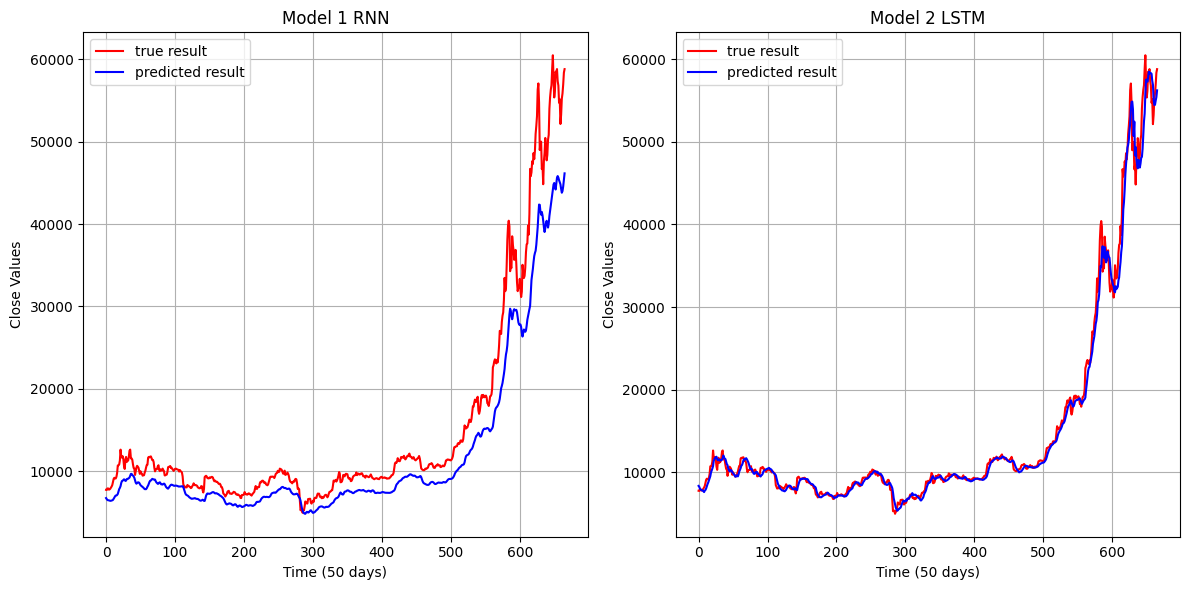

In [115]:
import matplotlib.pyplot as plt

# Membuat figure dan axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot pertama
ax1.plot(test_labels, color="r", label="true result")
ax1.plot(model_1_preds, color="b", label="predicted result")
ax1.legend()
ax1.set_xlabel("Time (50 days)")
ax1.set_ylabel("Close Values")
ax1.set_title("Model 1 RNN")
ax1.grid(True)

# Plot kedua
ax2.plot(test_labels, color="r", label="true result")
ax2.plot(model_2_preds, color="b", label="predicted result")
ax2.legend()
ax2.set_xlabel("Time (50 days)")
ax2.set_ylabel("Close Values")
ax2.set_title("Model 2 LSTM")
ax2.grid(True)

# Menampilkan plot
plt.tight_layout()
plt.show()

In [137]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"model 1 (RNN)": model_1_results,
                              "model 2 (LSTM)": model_2_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
model 1 (RNN),3170.4219,19803716.0,4450.1367,20.018940,8.433455
model 2 (LSTM),660.5167,1464885.1,1210.3243,3.979325,1.757002


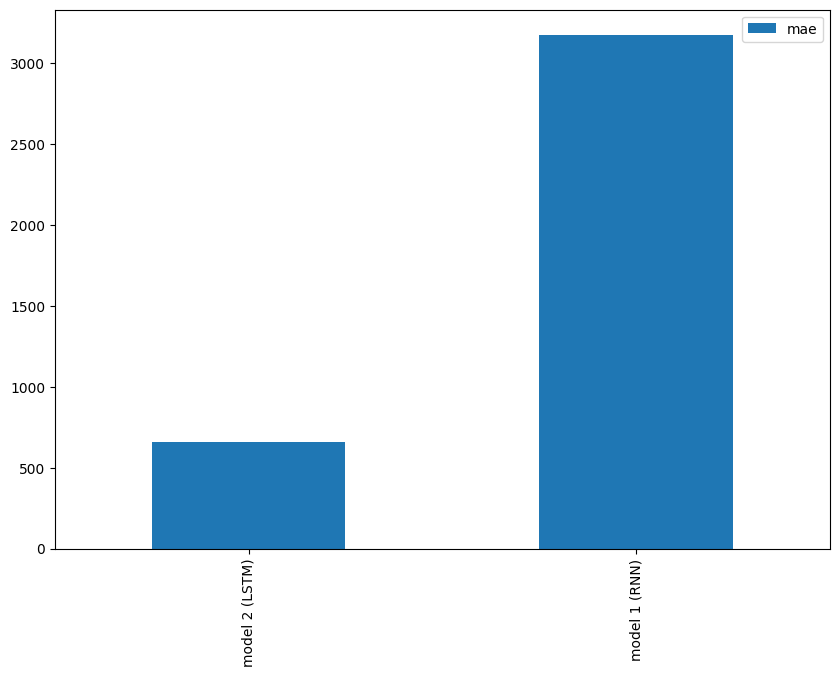

In [138]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");